In [53]:
import pandas as pd
import polars as pl
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import pickle
from datetime import datetime
from scipy.stats import spearmanr, pearsonr, kendalltau, pointbiserialr

DATA_ROOT = "/media/gustavo/Storage/Datasets/Onion20k"
DATA_ROOT_URL = Path(DATA_ROOT)
sns.set_theme()
plt.rcParams["figure.dpi"] = 100

In [8]:
full_feat_tracks = pd.read_csv(
    DATA_ROOT_URL / "v2_emotions_familiarity_full_feat_stack.tsv", sep="\t"
)

In [5]:
full_feat_tracks.describe()


,row_id,score,lfm_id,year,month,day
count,40399.000000,40399.000000,40399.000000,40399.000000,40399.000000,40399.000000
mean,8247.986510,16.125176,12097.687542,2000.407609,4.756430,10.334142
std,4771.981083,25.200520,7066.854250,11.712403,3.702617,9.863927
min,0.000000,1.000000,1.000000,1900.000000,1.000000,1.000000
25%,4118.000000,4.000000,5941.000000,1996.000000,1.000000,1.000000
50%,8245.000000,7.000000,12063.000000,2004.000000,4.000000,7.000000
75%,12389.500000,17.000000,18170.500000,2008.000000,8.000000,19.000000
max,16454.000000,400.000000,24407.000000,2021.000000,12.000000,31.000000


In [6]:
full_feat_tracks["gem_label"].value_counts()

transcendence        7523
joyful activation    6006
nostalgia            5503
power                5192
wonder               5084
peacefulness         4211
sadness              4150
tension              1637
tenderness           1093
Name: gem_label, dtype: int64

In [13]:
full_feat_tracks.lfm_id.nunique()


16435

In [8]:
import polars as pl


def calculate_pop(data):
    # Generating item popularity  (Abdollahpouri'17) (Kowald'22)  Pop_i = |U_i|/|U|
    unique_users = data.select(["user_id"]).collect()["user_id"].n_unique()
    item_popularity = (
        data.groupby(["track_id"])
        .agg(
            [
                (pl.col("user_id").n_unique() / unique_users).alias("pop_i"),
                pl.count().alias("track_playcount"),
            ]
        )
        .sort("pop_i", reverse=True)
        .collect()
    )
    return item_popularity


def calculate_familiarity(data, R=3):
    # Generating item popularity  (Abdollahpouri'17) (Kowald'22)  Pop_i = |U_i|/|U|
    unique_users = data.select(["user_id"]).collect()["user_id"].n_unique()
    item_familiarity = (
        data.groupby(["track_id", "user_id"])
        .agg([pl.count().alias("user_track_playcount")])
        .filter(pl.col("user_track_playcount") >= R)
        .groupby(["track_id"])
        .agg(pl.col("user_id").n_unique().alias("num_fam_users"))
        .with_column((pl.col("num_fam_users") / unique_users).alias("fam_i"))
        .sort("fam_i", reverse=True)
        .collect()
    )
    return item_familiarity


def get_ur_timeframe(data, offset="1mo"):
    return (
        data.with_column(
            (pl.col("timestamp").min().dt.offset_by(offset).alias("ts_ref")).over(
                pl.col(["track_id", "user_id"])
            )
        )
        .with_column(
            (pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
        )
        .filter(pl.col("ts_diff") > 0)
    )


def get_ss_timeframe(data, release_dates, offset="1mo"):
    release_dates_data = data.join(
        release_dates, left_on="track_id", right_on="lfm_id", how="inner"
    )
    return (
        release_dates_data.with_column(
            (pl.col("release_data").first().dt.offset_by(offset).alias("ts_ref")).over(
                pl.col(["track_id", "user_id"])
            )
        )
        .with_column(
            (pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
        )
        .filter(pl.col("ts_diff") > 0)
    )


def calculate_tpop(
    data,
    offset,
):
    unique_users = data.select(["user_id"]).collect()["user_id"].n_unique()
    item_popularity = (
        data.pipe(get_ur_timeframe, offset=offset)
        .groupby(["track_id"])
        .agg(
            [
                (pl.col("user_id").n_unique() / unique_users).alias("pop_i"),
                pl.count().alias("track_playcount"),
            ]
        )
        .sort("t_pop_i", reverse=True)
        .collect()
    )
    return item_popularity

In [9]:
def calculate_bll_score_global(data, decay=0.5):
    return (
        data.with_column(
            (pl.col("timestamp").max().dt.offset_by("1h").alias("ts_ref")).over(
                pl.col(["user_id"])
            )
        )
        .with_column(
            (pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
        )
        .filter(pl.col("ts_diff") > 0)
        .groupby(["track_id", "user_id"])
        .agg([pl.col("ts_diff").pow(-decay).sum().log().alias("bll_score")])
        .groupby("track_id")
        .agg(pl.col("bll_score").mean())
    )


def calculate_bll_score(data, offset="2w1h", decay=0.5):
    return (
        data.with_column(
            (pl.col("timestamp").min().dt.offset_by(offset).alias("ts_ref")).over(
                pl.col(["track_id", "user_id"])
            )
        )
        .with_column(
            (pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
        )
        .filter(pl.col("ts_diff") > 0)
        .groupby(["track_id", "user_id"])
        .agg([(pl.col("ts_diff").pow(-decay).sum()).log().alias("bll_score")])
        .groupby("track_id")
        .agg(pl.col("bll_score").mean())
    )


def calculate_bll_score_min_freq(data, offset="2w1h", decay=0.5, R=3):
    return (
        data.with_column(
            (pl.col("timestamp").min().dt.offset_by(offset).alias("ts_ref")).over(
                pl.col(["track_id", "user_id"])
            )
        )
        .with_column(
            (pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
        )
        .filter((pl.col("ts_diff") > 0))
        .groupby(["track_id", "user_id"])
        .agg(
            [
                (pl.col("ts_diff").pow(-decay).sum()).log().alias("bll_score"),
                pl.col("ts_diff").count().alias("count"),
            ]
        )
        .filter(pl.col("count") >= R)
        .groupby("track_id")
        .agg(pl.col("bll_score").mean())
    )

# Calculating popularity measures

In [2]:
data = pl.scan_csv(DATA_ROOT_URL / "user_item_timestamp.tsv", sep="\t").rename(
    mapping={"track_index": "track_id", "time": "timestamp"}
)

In [144]:
!wc -l {DATA_ROOT_URL}/user_item_timestamp.tsv

230884331 /media/gustavo/Storage/Datasets/Onion20k/user_item_timestamp.tsv


In [11]:
items_inter = data.select(pl.col("track_id").unique()).collect()

In [14]:
np.intersect1d(
    items_inter, full_feat_tracks.lfm_id.unique()
).shape, full_feat_tracks.lfm_id.nunique()

((16432,), 16435)

In [50]:
data.filter(pl.col("track_id").is_in(pl.lit(merged_data["lfm_id"].unique()))).select(
    pl.col("user_id").n_unique()
).collect()

user_id
u32
118289


In [4]:
itempop_all = calculate_pop(data)

In [6]:
itempop_all.write_csv(DATA_ROOT_URL / "track_all_popularity.csv")

In [22]:
itemfam_all = calculate_familiarity(data, R=20)

In [23]:
itemfam_all.write_csv(DATA_ROOT_URL / "track_all_familiarity.csv")

In [17]:
itemfam5_all = calculate_familiarity(data, R=5)
itemfam5_all.write_csv(DATA_ROOT_URL / "track_all_familiarity5.csv")

In [55]:
offset = "1mo"
decay = 0.5
min_freq = 3
data = pl.scan_csv(
    DATA_ROOT_URL / "user_item_timestamp.tsv", sep="\t", parse_dates=True
).rename(mapping={"track_index": "track_id", "time": "timestamp"})
data.pipe(calculate_bll_score, offset=offset, decay=decay).collect().write_csv(
    DATA_ROOT_URL / f"bll_scores_{offset}.csv"
)
data.pipe(
    calculate_bll_score_min_freq, offset=offset, decay=decay, R=min_freq
).collect().write_csv(DATA_ROOT_URL / f"bll_scores_minfreq_{offset}.csv")
# data.pipe(calculate_bll_score_global,decay=decay).collect().write_csv(DATA_ROOT_URL/f"bll_scores_global.csv")

# Calculating correlations (Onion/EMMA)

|**Metric**|**Description**|
|----------|---------------|
|$Pop(i)$ |**Global popularity** : Relative proportion of unique listeners per track|
|$Fam(i)$ |**Global familiarity** : Relative proportion of users that played the track at least R>=3 and all unique listeners of that same track|
|$TFam_{BL}(i)$ |**Average user BLL score in Timeframe**: Calculate BLL for each (user,track) pair in the timewindow='1mo' after the first interaction  of the user with the track. Then group (user,track,bll_score) by track aggregating as the  mean of the bll_scores for each item|  

In [46]:
itempop_all = pd.read_csv(DATA_ROOT_URL / "track_all_popularity.csv")
itemfam_all = pd.read_csv(DATA_ROOT_URL / "track_all_familiarity.csv")
itemfam5_all = pd.read_csv(DATA_ROOT_URL / "track_all_familiarity5.csv")
itembll_all = pd.read_csv(DATA_ROOT_URL / "bll_scores_global.csv")
t_itembll_all = pd.read_csv(DATA_ROOT_URL / "bll_scores_1mo.csv")
merged_data = full_feat_tracks.merge(
    itempop_all, left_on="lfm_id", right_on="track_id", how="inner"
)
merged_data = merged_data.merge(
    itemfam_all, left_on="lfm_id", right_on="track_id", how="left", suffixes=["", "_f"]
)
merged_data = merged_data.merge(
    itembll_all, left_on="lfm_id", right_on="track_id", how="left", suffixes=["", "_3"]
)
merged_data = merged_data.merge(
    t_itembll_all,
    left_on="lfm_id",
    right_on="track_id",
    how="left",
    suffixes=["", "_t"],
)
merged_data.loc[merged_data["fam_i"].isna(), "fam_i"] = 0.0
merged_data.loc[merged_data["bll_score"].isna(), "bll_score"] = 0.0
merged_data.loc[merged_data["bll_score_t"].isna(), "bll_score_t"] = 0.0
gems_groups = merged_data.groupby("gem_label")

In [166]:
merged_data.drop_duplicates("lfm_id")["track_playcount"].quantile(0.999)

123046.36000000004

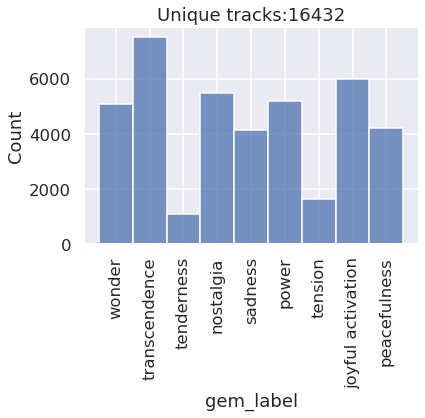

In [19]:
sns.set_context(sns.plotting_context("talk"))
sns.histplot(merged_data["gem_label"])
plt.xticks(rotation=90)
plt.title(f"Unique tracks:{merged_data['lfm_id'].nunique()}")
plt.show()

## Calculating correlations on groups of Tracks (Onion/EMMA) 

In [58]:
from collections import defaultdict

corr_all = defaultdict(lambda: list())
cols = ["bll_score", "bll_score_t", "pop_i", "fam_i"]
metrics = spearmanr, pearsonr, kendalltau  # pointbiserialr
for label, tracks in gems_groups:
    # print([len(tracks),tracks['lfm_id'].nunique(),(tracks['score']>0).sum()])
    corr_all["label"].append(label)
    corr_all[f"|label|"].append(tracks["score"].count())
    for col in cols:
        for metric in metrics:
            corr_val, pval = metric(tracks["score"], tracks[col])
            corr_all[f"{col}_{metric.__name__}"].append(corr_val)

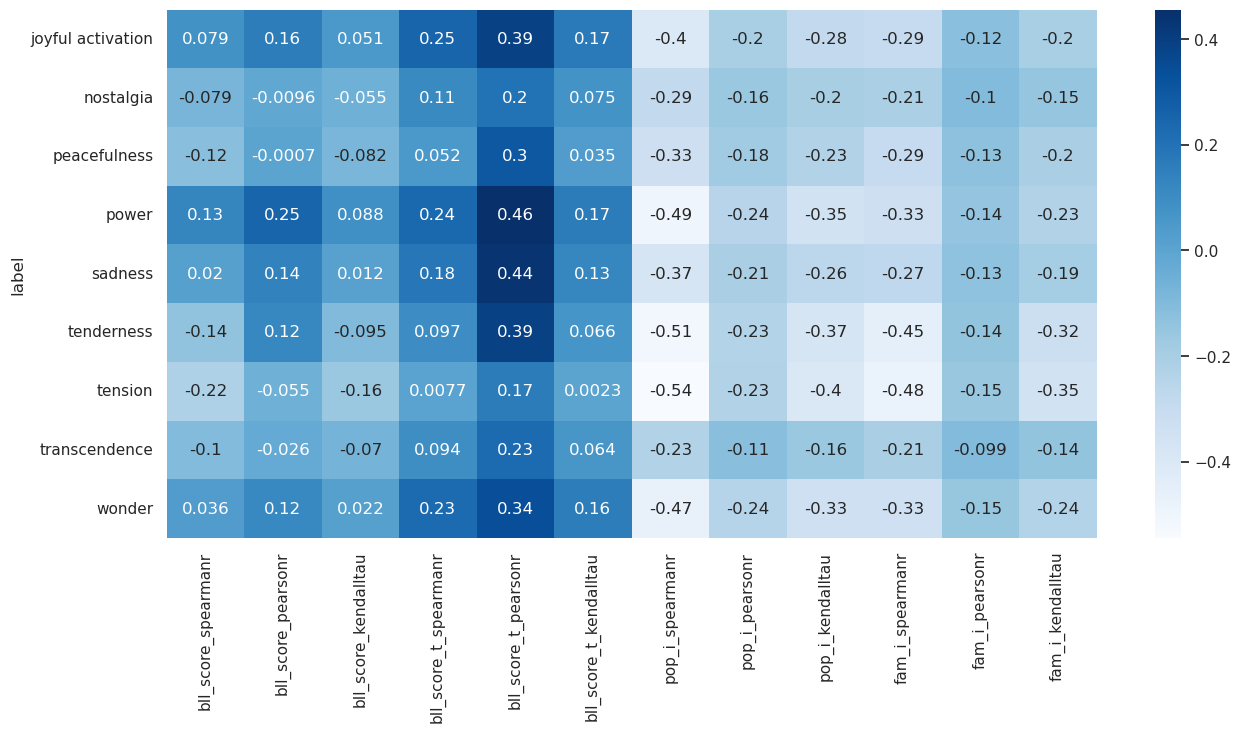

In [59]:
corr_df = pd.DataFrame(corr_all)
corr_df.set_index("label", inplace=True)
with sns.plotting_context("notebook"):
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_df.iloc[:, 1:], annot=True, cmap="Blues")

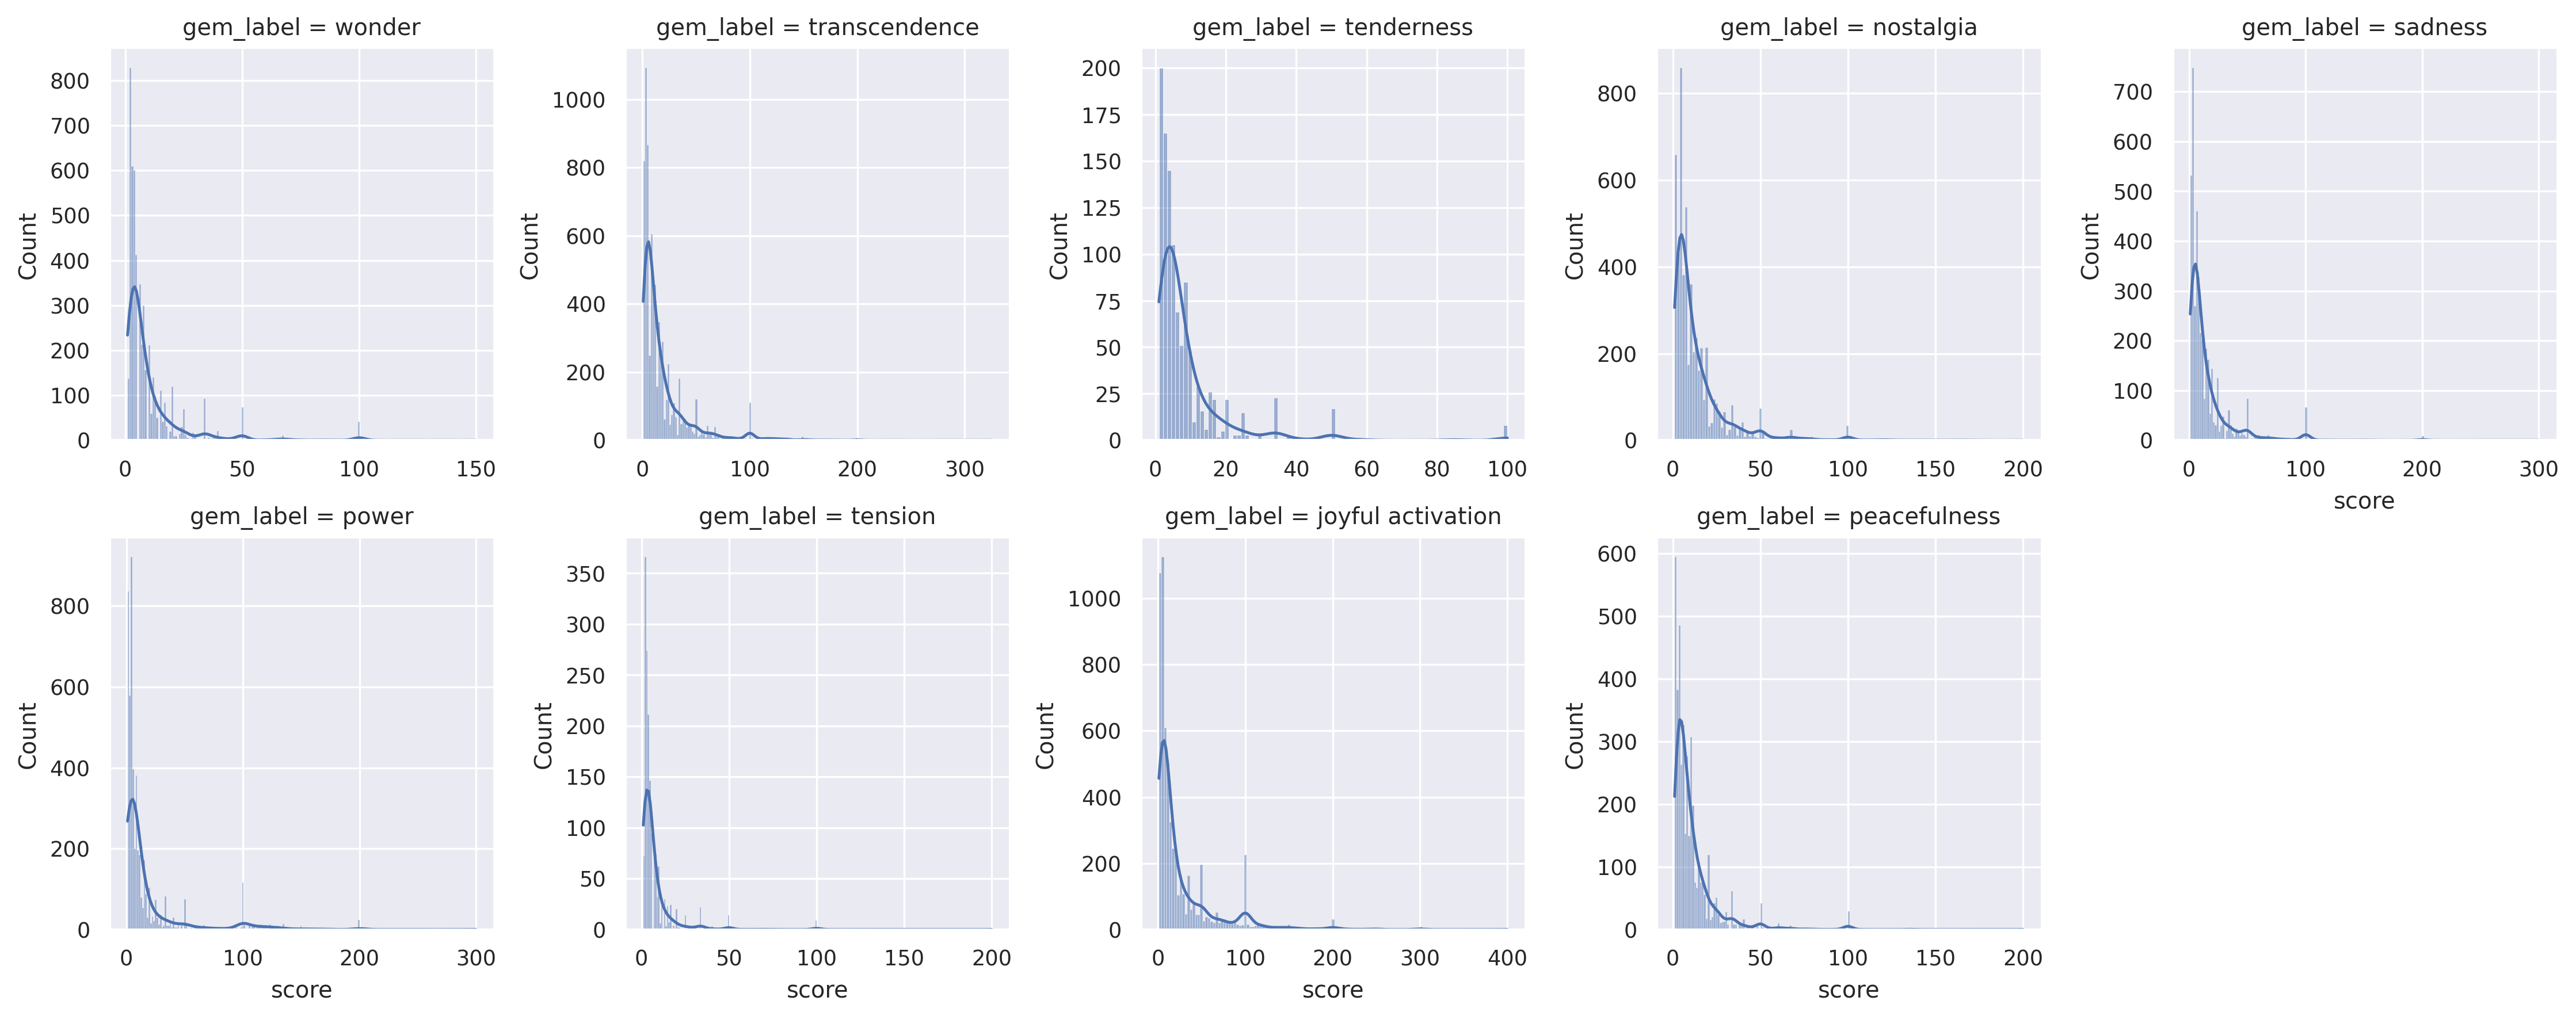

In [39]:
sns.set_context(sns.plotting_context("paper"))
g = sns.FacetGrid(merged_data, col="gem_label", col_wrap=5, sharey=False, sharex=False)
g = g.map(sns.histplot, "score", kde=True)

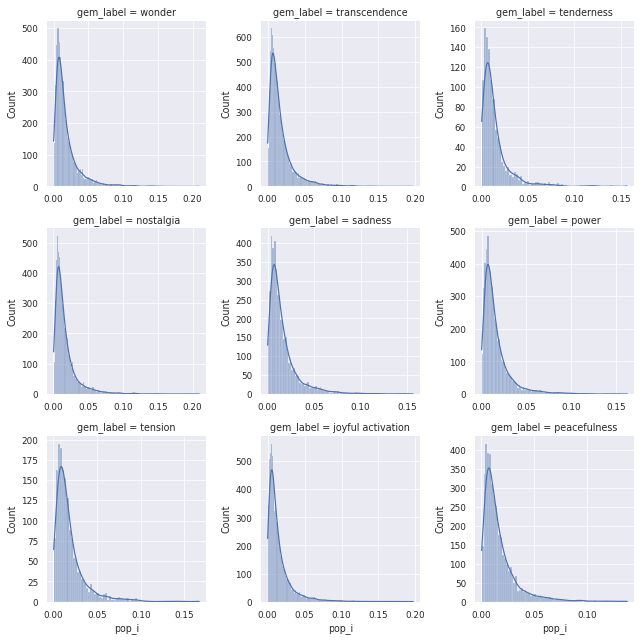

In [24]:
g = sns.FacetGrid(merged_data, col="gem_label", col_wrap=3, sharey=False, sharex=False)
g = g.map(sns.histplot, "pop_i", kde=True)

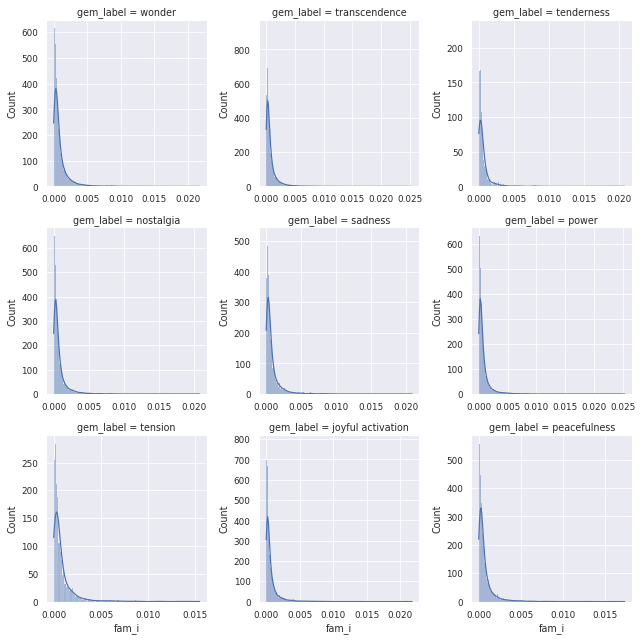

In [25]:
g = sns.FacetGrid(merged_data, col="gem_label", col_wrap=3, sharey=False, sharex=False)
g = g.map(sns.histplot, "fam_i", kde=True)

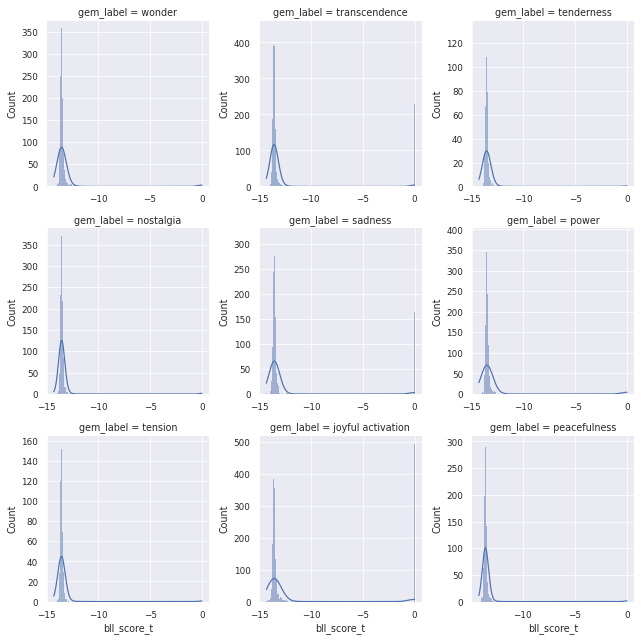

In [28]:
g = sns.FacetGrid(merged_data, col="gem_label", col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.histplot, "bll_score_t", kde=True)

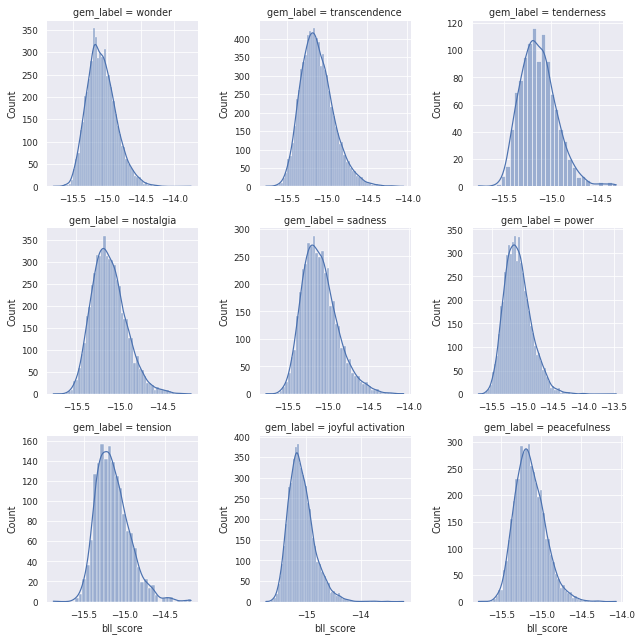

In [30]:
g = sns.FacetGrid(merged_data, col="gem_label", col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.histplot, "bll_score", kde=True)

## Calculation of correlation bewtween EMMA labels with audio features (Onion/EMMA)

In [154]:
audio_features = pd.read_csv(DATA_ROOT_URL / "emotion_audiofeatures.csv")
lfm_listening_counts = pd.read_csv(
    DATA_ROOT_URL / "lfm_listening_counts.csv",
    skiprows=1,
    names=["lfm_id", "listening_count"],
)
merged_data = full_feat_tracks.merge(
    audio_features, left_on="lfm_id", right_on="lfm_id", how="inner"
).dropna(subset="valence")
itempop_all = pd.read_csv(DATA_ROOT_URL / "track_all_popularity.csv")
itemfam_all = pd.read_csv(DATA_ROOT_URL / "track_all_familiarity.csv")
merged_data = merged_data.merge(
    itempop_all, left_on="lfm_id", right_on="track_id", how="inner"
)
merged_data = merged_data.merge(
    itemfam_all, left_on="lfm_id", right_on="track_id", how="inner", suffixes=["", "_3"]
)
merged_data = merged_data.merge(
    lfm_listening_counts,
    left_on="lfm_id",
    right_on="lfm_id",
    how="inner",
    suffixes=["", "_3"],
)
gems_groups = merged_data.groupby("gem_label")
from collections import defaultdict

corr_all = defaultdict(lambda: list())
cols = ["valence", "pop_i", "fam_i", "listening_count"]
cols = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]
for label, tracks in gems_groups:
    # print([len(tracks),tracks['lfm_id'].nunique(),(tracks['score']>0).sum()])
    corr_all["label"].append(label)
    for col in cols:
        corr_val, pval = spearmanr(tracks[["score", col]])
        corr_all[f"{col}"].append(corr_val)

In [77]:
audio_features.columns


Index(['Unnamed: 0', 'lfm_id', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature'],
      dtype='object')

In [36]:
corr_df = pd.DataFrame(corr_all)
# corr_df.set_index('group',inplace=True)
cm = sns.color_palette("Blues", as_cmap=True)
s = corr_df.style.background_gradient(cmap=cm, subset=corr_df.columns[2:]).hide(
    axis="index"
)
print(
    s.to_latex(
        hrules=True,
        clines="skip-last;index",
        caption="table",
        position_float="centering",
        multicol_align="l",
        convert_css=True,
    )
)

\begin{table}
\centering
\caption{table}
\begin{tabular}{lrrrrr}
\toprule
label & |label| & bll_score_spearmanr & bll_score_t_spearmanr & pop_i_spearmanr & fam_i_spearmanr \\
\midrule
joyful activation & 6006 & {\cellcolor[HTML]{0C56A0}} \color[HTML]{F1F1F1} 0.078774 & {\cellcolor[HTML]{08306B}} \color[HTML]{F1F1F1} 0.251082 & {\cellcolor[HTML]{7CB7DA}} \color[HTML]{000000} -0.400533 & {\cellcolor[HTML]{3383BE}} \color[HTML]{F1F1F1} -0.293224 \\
nostalgia & 5502 & {\cellcolor[HTML]{92C4DE}} \color[HTML]{000000} -0.079144 & {\cellcolor[HTML]{8ABFDD}} \color[HTML]{000000} 0.110708 & {\cellcolor[HTML]{125EA6}} \color[HTML]{F1F1F1} -0.286231 & {\cellcolor[HTML]{083370}} \color[HTML]{F1F1F1} -0.211127 \\
peacefulness & 4211 & {\cellcolor[HTML]{B7D4EA}} \color[HTML]{000000} -0.117001 & {\cellcolor[HTML]{D3E4F3}} \color[HTML]{000000} 0.052070 & {\cellcolor[HTML]{2F7FBC}} \color[HTML]{F1F1F1} -0.325944 & {\cellcolor[HTML]{3080BD}} \color[HTML]{F1F1F1} -0.290416 \\
power & 5191 & {\cellcolor[HT

In [37]:
s


label,|label|,bll_score_spearmanr,bll_score_t_spearmanr,pop_i_spearmanr,fam_i_spearmanr
joyful activation,6006,0.078774,0.251082,-0.400533,-0.293224
nostalgia,5502,-0.079144,0.110708,-0.286231,-0.211127
peacefulness,4211,-0.117001,0.052070,-0.325944,-0.290416
power,5191,0.131026,0.238877,-0.494065,-0.328186
sadness,4149,0.019728,0.183625,-0.372940,-0.273599
tenderness,1093,-0.135640,0.096875,-0.510813,-0.449454
tension,1637,-0.222288,0.007728,-0.544276,-0.478550
transcendence,7523,-0.101648,0.093990,-0.230855,-0.206890
wonder,5083,0.036128,0.232946,-0.468956,-0.334817


## Calculating correlations on binarized EMMA labels (Onion/EMMA)

In [18]:
audio_features = pd.read_csv(DATA_ROOT_URL / "emotion_audiofeatures.csv")
lfm_listening_counts = pd.read_csv(
    DATA_ROOT_URL / "lfm_listening_counts.csv",
    skiprows=1,
    names=["lfm_id", "listening_count"],
)
merged_data = full_feat_tracks.merge(
    audio_features, left_on="lfm_id", right_on="lfm_id", how="inner"
).dropna(subset="valence")
itempop_all = pd.read_csv(DATA_ROOT_URL / "track_all_popularity.csv")
itemfam_all = pd.read_csv(DATA_ROOT_URL / "track_all_familiarity.csv")
merged_data = merged_data.merge(
    itempop_all, left_on="lfm_id", right_on="track_id", how="inner"
)
merged_data = merged_data.merge(
    itemfam_all, left_on="lfm_id", right_on="track_id", how="inner", suffixes=["", "_3"]
)
merged_data = merged_data.merge(
    lfm_listening_counts,
    left_on="lfm_id",
    right_on="lfm_id",
    how="inner",
    suffixes=["", "_3"],
)
gems_groups = merged_data.groupby("gem_label")

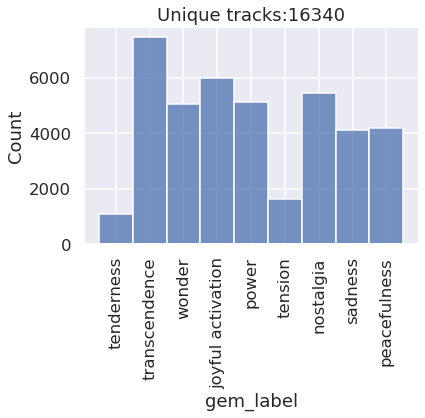

In [19]:
sns.set_context(sns.plotting_context("talk"))
sns.histplot(merged_data["gem_label"])
plt.xticks(rotation=90)
plt.title(f"Unique tracks:{merged_data['lfm_id'].nunique()}")
plt.show()

In [20]:
merged_data = merged_data.drop_duplicates(["lfm_id"]).merge(
    merged_data.pivot(columns="gem_label", index="lfm_id", values="score"),
    left_on="lfm_id",
    right_index=True,
    how="inner",
)

In [21]:
from collections import defaultdict

corr_all = defaultdict(lambda: list())
cols = ["valence", "pop_i", "fam_i", "listening_count"]
cols = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]
for label, tracks in gems_groups:
    # print([len(tracks),tracks['lfm_id'].nunique(),(tracks['score']>0).sum()])
    corr_all["label"].append(label)
    for col in cols:
        corr_val, pval = spearmanr(tracks[["score", col]])
        corr_all[f"{col}"].append(corr_val)

In [22]:
from collections import defaultdict

corr_all = defaultdict(lambda: list())

cols_e = merged_data.columns[-9:]
cols_p = ["pop_i", "fam_i"]
for e in cols_e:
    corr_all["label"].append(e)
    for p in cols_p:
        corr_val, pval = pointbiserialr(merged_data[p], merged_data[e].notna())
        corr_all[f"{p}"].append(corr_val)

<AxesSubplot:ylabel='label'>

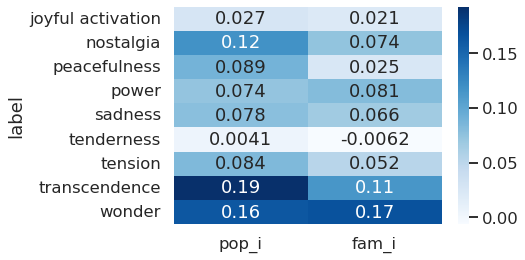

In [24]:
corr_df = pd.DataFrame(corr_all)
corr_df.set_index("label", inplace=True)
sns.heatmap(corr_df, annot=True, cmap="Blues")

# Calculating correlations on EMMA tracks

In [75]:
emma_database_merged = pd.read_csv(DATA_ROOT_URL / "emma_database_merge.csv")
itembll_all = pd.read_csv(DATA_ROOT_URL / "bll_scores_global.csv")
merged_data = emma_database_merged.merge(
    itempop_all, left_on="lfm_id", right_on="track_id", how="inner"
)
merged_data = merged_data.merge(
    itemfam_all, left_on="lfm_id", right_on="track_id", how="left", suffixes=["", "_3"]
)
merged_data = merged_data.merge(
    itembll_all, left_on="lfm_id", right_on="track_id", how="left", suffixes=["", "_3"]
)
merged_data.loc[merged_data["bll_score"].isna(), "bll_score"] = 0.0
merged_data.loc[merged_data["fam_i"].isna(), "fam_i"] = 0.0
corr, pval = spearmanr(
    merged_data[
        [
            "Wonder",
            "Transcendence",
            "Nostalgia",
            "Tenderness",
            "Peacfulness",
            "Joy",
            "Power",
            "Tension",
            "Sadness",
            "Sublimity",
            "Vitality",
            "Unease",
            "ICC",
            "Familiarity",
            "Liking",
            "pop_i",
            "fam_i",
            "bll_score",
        ]
    ]
)

<AxesSubplot:title={'center':'Matching tracks Music4All-Emma :43'}>

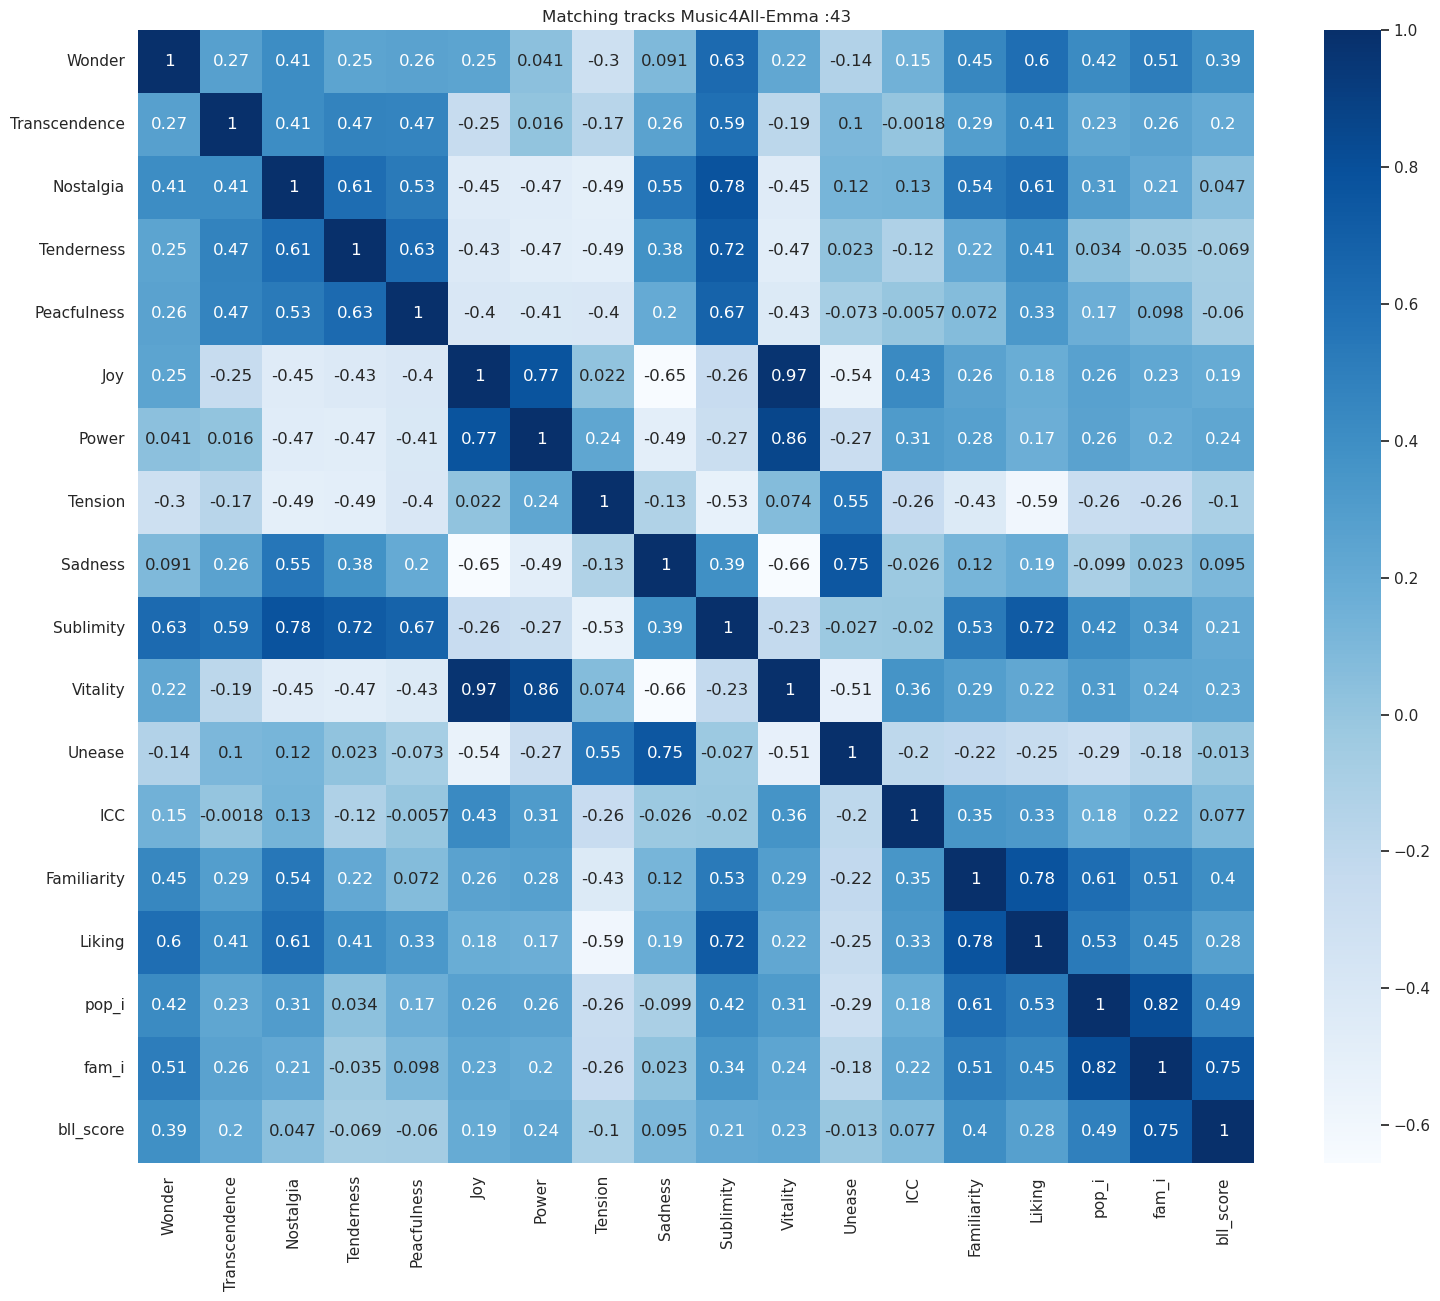

In [76]:
plt.figure(figsize=(18, 15))
plt.title(f"Matching tracks Music4All-Emma :{len(merged_data)}")
sns.heatmap(
    merged_data[
        [
            "Wonder",
            "Transcendence",
            "Nostalgia",
            "Tenderness",
            "Peacfulness",
            "Joy",
            "Power",
            "Tension",
            "Sadness",
            "Sublimity",
            "Vitality",
            "Unease",
            "ICC",
            "Familiarity",
            "Liking",
            "pop_i",
            "fam_i",
            "bll_score",
        ]
    ].corr(),
    annot=True,
    cmap="Blues",
)

<AxesSubplot:ylabel='Frequency'>

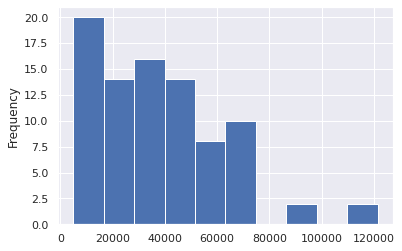

In [153]:
merged_data["track_playcount"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

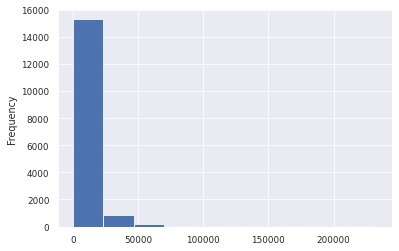

In [67]:
merged_data.drop_duplicates("lfm_id")["track_playcount"].plot.hist()

In [143]:
emma_database_merged = pd.read_csv(DATA_ROOT_URL / "emma_database_merge.csv").iloc[:,:27]
full_feat_tracks = pd.read_csv(
    DATA_ROOT_URL / "v2_emotions_familiarity_full_feat_stack.tsv", sep="\t"
)
itembll_all = pd.read_csv(DATA_ROOT_URL / "bll_scores_global.csv")
merged_data = full_feat_tracks.join(
    emma_database_merged, on="lfm_id", how="inner", rsuffix="_emma"
)

# merged_data = merged_data.merge(itemfam_all,left_on='lfm_id',right_on='track_id',how='left',suffixes=["","_3"])
# merged_data = merged_data.merge(itempop_all,left_on='lfm_id',right_on='track_id',how='inner',suffixes=["","_3"])
# merged_data = merged_data.merge(itembll_all,left_on='lfm_id',right_on='track_id',how='left',suffixes=["","_3"])
# merged_data.loc[merged_data['bll_score'].isna(),'bll_score']=0.0
# merged_data.loc[merged_data['fam_i'].isna(),'fam_i']=0.0

In [144]:
merged_data.columns


Index(['row_id', 'gem_label', 'score', 'track_uri', 'date', 'date_prec', 'id',
       'gems', 'gems_profile', 'gems_profile_no_rescaling', 'genre',
       'microgenre', 'lfm_id', 'year', 'month', 'day', 'release_date',
       'Unnamed: 0', 'artist', 'title', 'Wonder', 'Transcendence', 'Nostalgia',
       'Tenderness', 'Peacfulness', 'Joy', 'Power', 'Tension', 'Sadness',
       'Sublimity', 'Vitality', 'Unease', 'ICC', 'Familiarity', 'Liking',
       '_id', 'track', 'album', 'lfm', 'spotify', 'id_emma', '(tag, weight)',
       'gems_emma', 'gems_profile_emma'],
      dtype='object')

In [149]:
gems_groups = merged_data.groupby("gem_label")
from collections import defaultdict

corr_all = defaultdict(lambda: list())
cols = [
    "Joy",
    "Nostalgia",
    "Peacfulness",
    "Power",
    "Sadness",
    "Tenderness",
    "Tension",
    "Transcendence",
    "Wonder",
    "Familiarity",
]
for label, tracks in gems_groups:
    
    # print([len(tracks),tracks['lfm_id'].nunique(),(tracks['score']>0).sum()])
    corr_all["label"].append(label)
    for col in cols:
        print(tracks[["score", col]])
        corr_val, pval = spearmanr(tracks[["score", col]])
        corr_all[f"{col}"].append(corr_val)

       score    Joy
1888    57.0   8.35
4469   111.0  33.57
9825     3.0  38.62
14368    8.0  16.82
30118   10.0  26.35
31957   71.0  31.77
33300  100.0   9.77
36898   10.0  32.85
39315    4.0  11.01
       score  Nostalgia
1888    57.0      14.90
4469   111.0      12.66
9825     3.0      11.71
14368    8.0       6.76
30118   10.0       8.75
31957   71.0      21.86
33300  100.0      20.14
36898   10.0      27.54
39315    4.0      25.95
       score  Peacfulness
1888    57.0        22.78
4469   111.0         4.45
9825     3.0        12.31
14368    8.0         8.67
30118   10.0         6.74
31957   71.0         8.39
33300  100.0        15.92
36898   10.0        13.58
39315    4.0        26.23
       score  Power
1888    57.0   5.20
4469   111.0  20.87
9825     3.0  14.54
14368    8.0   3.95
30118   10.0  17.14
31957   71.0  16.17
33300  100.0   3.24
36898   10.0   5.92
39315    4.0   2.12
       score  Sadness
1888    57.0     1.17
4469   111.0     0.00
9825     3.0     2.21
14368    8.0

: 

In [139]:
gems_groups["lfm_id"].count()

gem_label
joyful activation     9
nostalgia            10
peacefulness          8
power                11
sadness               8
tenderness            4
tension               5
transcendence        11
wonder               11
Name: lfm_id, dtype: int64

Text(0.5, 1.0, 'Total tracks:30')

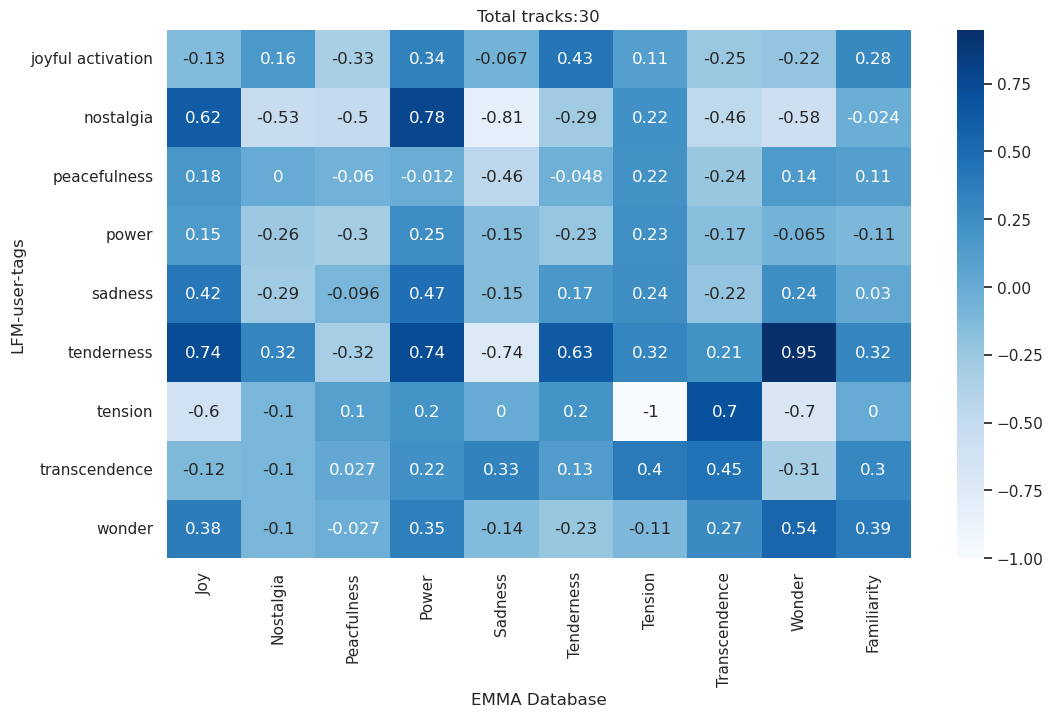

In [147]:
corr_df = pd.DataFrame(corr_all)
corr_df.set_index("label", inplace=True)
corr_df.index.name = "LFM-user-tags"
corr_df.columns.name = "EMMA Database"
plt.figure(figsize=(12, 7))
sns.heatmap(corr_df, cmap="Blues", annot=True)
plt.title(f'Total tracks:{merged_data["lfm_id"].nunique()}')

In [146]:
merged_data

,row_id,gem_label,score,track_uri,date,date_prec,id,gems,gems_profile,gems_profile_no_rescaling,...,Liking,_id,track,album,lfm,spotify,id_emma,"(tag, weight)",gems_emma,gems_profile_emma
1522,619,wonder,34.0,2aKd630BXs24Yt1znAty7Z,2002-01-01,day,05jXxX3fLknEmiqi,"['wonder', 'sadness']","{'wonder': 0.7727272727272727, 'sadness': 0.22...","{'wonder': 34.0, 'sadness': 10.0}",...,3.45,Dvv43ANkwiTz5fN6,Uptown Funk,Uptown Special,"{'track_id': 43021577, 'artist_id': 2668020, '...","{'uri': '32OlwWuMpZ6b0aN2RZOeMS', 'features': ...",Dvv43ANkwiTz5fN6,"{'funk': 100, 'dance': 65, 'bruno mars': 55, '...","['power', 'joyful activation']","{'power': 0.058823529411764705, 'joyful activa..."
1523,619,sadness,10.0,2aKd630BXs24Yt1znAty7Z,2002-01-01,day,05jXxX3fLknEmiqi,"['wonder', 'sadness']","{'wonder': 0.7727272727272727, 'sadness': 0.22...","{'wonder': 34.0, 'sadness': 10.0}",...,3.45,Dvv43ANkwiTz5fN6,Uptown Funk,Uptown Special,"{'track_id': 43021577, 'artist_id': 2668020, '...","{'uri': '32OlwWuMpZ6b0aN2RZOeMS', 'features': ...",Dvv43ANkwiTz5fN6,"{'funk': 100, 'dance': 65, 'bruno mars': 55, '...","['power', 'joyful activation']","{'power': 0.058823529411764705, 'joyful activa..."
1887,758,nostalgia,12.0,6eOSSJTrIDi0WAmLOFr4wh,1986-09-29,day,02uQlK780Tu47T5Q,"['nostalgia', 'joyful activation']","{'nostalgia': 0.17391304347826086, 'joyful act...","{'nostalgia': 12.0, 'joyful activation': 57.0}",...,2.92,HBMqZB9ngvubiKfs,Words,Horizontal (Deluxe Version),"{'track_id': 45383240, 'artist_id': 556212, 'a...","{'uri': '07PIhdmyYIw8dMeDMsx9FU', 'features': ...",HBMqZB9ngvubiKfs,"{'pop': 100, 'oldies': 89, '70s': 68, 'bee gee...","['transcendence', 'nostalgia', 'peacefulness',...","{'transcendence': 0.125, 'nostalgia': 0.375, '..."
1888,758,joyful activation,57.0,6eOSSJTrIDi0WAmLOFr4wh,1986-09-29,day,02uQlK780Tu47T5Q,"['nostalgia', 'joyful activation']","{'nostalgia': 0.17391304347826086, 'joyful act...","{'nostalgia': 12.0, 'joyful activation': 57.0}",...,2.92,HBMqZB9ngvubiKfs,Words,Horizontal (Deluxe Version),"{'track_id': 45383240, 'artist_id': 556212, 'a...","{'uri': '07PIhdmyYIw8dMeDMsx9FU', 'features': ...",HBMqZB9ngvubiKfs,"{'pop': 100, 'oldies': 89, '70s': 68, 'bee gee...","['transcendence', 'nostalgia', 'peacefulness',...","{'transcendence': 0.125, 'nostalgia': 0.375, '..."
2882,1168,peacefulness,2.0,6UWWzTU1NgKf7vHbOeO17p,1984-03-27,day,0273l5ZKx90qFfxJ,['peacefulness'],{'peacefulness': 1.0},{'peacefulness': 2.0},...,2.90,PiTkOYDEcg1Nrj8M,Harder Than You Think,How You Sell Soul to a Soulless People Who Sol...,"{'track_id': 17774188, 'artist_id': 3293831, '...","{'uri': '5YpZh8wfS4moRBk0ijNcXr', 'features': ...",PiTkOYDEcg1Nrj8M,"{'hip hop': 59, 'rap': 59, 'public enemy': 36,...","['wonder', 'joyful activation']","{'wonder': 0.6666666666666666, 'joyful activat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39312,16047,transcendence,23.0,4BmtCb6sdMqECAItGmFDvU,2006-09-04,day,04OjszRi9rC5BlHC,"['wonder', 'transcendence', 'peacefulness', 'j...","{'wonder': 0.14285714285714285, 'transcendence...","{'wonder': 8.0, 'transcendence': 23.0, 'peacef...",...,3.50,zbI3TrMSY2chqzRz,White Flag,Life For Rent,"{'track_id': 44880409, 'artist_id': 1211115, '...","{'uri': '3adnLFXKO5rC1lhUNSeg3N', 'features': ...",zbI3TrMSY2chqzRz,"{'pop': 100, 'female vocalists': 65, 'dido': 4...","['transcendence', 'nostalgia', 'peacefulness',...","{'transcendence': 0.6333333333333333, 'nostalg..."
39313,16047,sadness,4.0,4BmtCb6sdMqECAItGmFDvU,2006-09-04,day,04OjszRi9rC5BlHC,"['wonder', 'transcendence', 'peacefulness', 'j...","{'wonder': 0.14285714285714285, 'transcendence...","{'wonder': 8.0, 'transcendence': 23.0, 'peacef...",...,3.50,zbI3TrMSY2chqzRz,White Flag,Life For Rent,"{'track_id': 44880409, 'artist_id': 1211115, '...","{'uri': '3adnLFXKO5rC1lhUNSeg3N', 'features': ...",zbI3TrMSY2chqzRz,"{'pop': 100, 'female vocalists': 65, 'dido': 4...","['transcendence', 'nostalgia', 'peacefulness',...","{'transcendence': 0.63333333